<a href="https://colab.research.google.com/github/eliseleahy/Pytorch-Tutorials/blob/main/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Cunston Datasets

## 0. Importing Pytorch and setting up device agnostic code

In [7]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get some data

Dataset is a subset of Food101 dataset. (per image - 750 training, 250 test)

Dataset has only 3 classes adn only 10% of images (75 trainig, 25 testing)

In [8]:
import requests
import zipfile
from pathlib import Path

# set up path to Datafolder

data_path = Path("data/")
image_path = data_path / "piz za_steak_sushi"

if image_path.is_dir():
  print("path doesn't exist")
else:
  image_path.mkdir(parents=True, exist_ok=True)

# download data

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading data")
  f.write(request.content)

#unzip data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("unzipping data")
  zip_ref.extractall(image_path)

unzipping data


## 2. Data prepration and exploration

In [9]:
import os

def walk_through_dir(dir_path):
  """ Walks through dir path returing its contents"""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} dir and {len(filenames)} images in '{dirpath}.")

In [10]:
walk_through_dir(image_path)

There are 2 dir and 0 images in 'data/piz za_steak_sushi.
There are 3 dir and 0 images in 'data/piz za_steak_sushi/train.
There are 0 dir and 75 images in 'data/piz za_steak_sushi/train/steak.
There are 0 dir and 72 images in 'data/piz za_steak_sushi/train/sushi.
There are 0 dir and 78 images in 'data/piz za_steak_sushi/train/pizza.
There are 3 dir and 0 images in 'data/piz za_steak_sushi/test.
There are 0 dir and 19 images in 'data/piz za_steak_sushi/test/steak.
There are 0 dir and 31 images in 'data/piz za_steak_sushi/test/sushi.
There are 0 dir and 25 images in 'data/piz za_steak_sushi/test/pizza.


In [11]:
# Setup traing and test paths

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/piz za_steak_sushi/train'),
 PosixPath('data/piz za_steak_sushi/test'))

## 2.1 visualise an image

write some code to
1. get all the image path,
2. chosse a random image path,
3. get class name pathlib.Path.parent.stem
4. open image with PIL (pillow)
5. show image and print meta data


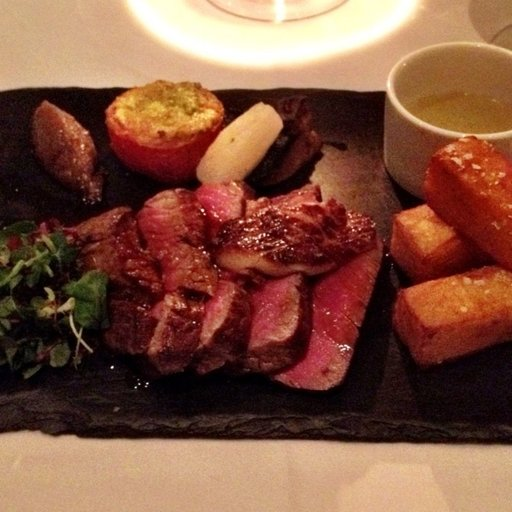

In [12]:
import random
from PIL import Image

#set seed
#random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)
random_image_path

image_class = random_image_path.parent.stem
image_class

img=Image.open(random_image_path)
img

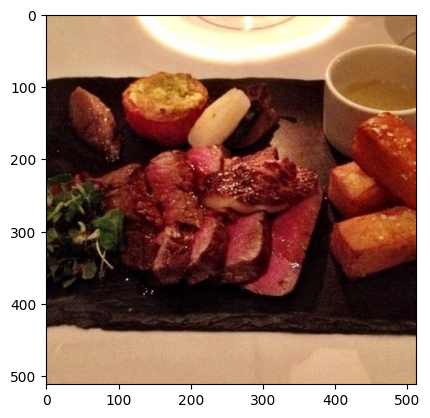

In [13]:
#2 visulise some images
import matplotlib.pyplot as plt

image = plt.imread(random_image_path)

plt.imshow(image)



In [14]:
import numpy as np

img_as_array = np.asarray(img)
img_as_array

array([[[211, 176, 138],
        [209, 174, 136],
        [207, 172, 134],
        ...,
        [159, 117,  69],
        [156, 114,  66],
        [159, 117,  69]],

       [[210, 175, 137],
        [208, 173, 135],
        [206, 171, 133],
        ...,
        [156, 114,  66],
        [157, 115,  67],
        [162, 120,  72]],

       [[208, 173, 135],
        [206, 171, 133],
        [205, 170, 132],
        ...,
        [155, 113,  65],
        [158, 116,  68],
        [161, 119,  71]],

       ...,

       [[201, 158, 126],
        [200, 157, 125],
        [201, 158, 124],
        ...,
        [207, 165, 123],
        [205, 163, 121],
        [202, 160, 118]],

       [[202, 157, 126],
        [200, 155, 124],
        [199, 156, 122],
        ...,
        [205, 163, 121],
        [204, 162, 120],
        [201, 159, 117]],

       [[202, 157, 126],
        [199, 154, 123],
        [198, 155, 121],
        ...,
        [205, 163, 121],
        [204, 162, 120],
        [202, 160, 118]]

##  3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (numerical representation of image)
2. Turn it into a 'torch.utils.data.Dataset' and subsequently a 'torch.utils.data.DataLoader'


In [15]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


## 3.1 transforing data with torrchvission.transforms

In [16]:
# write a transform for image
data_transform = transforms.Compose({
    #Resixe images to (64, 64)
    transforms.Resize(size=(64,64), antialias=True),
    # flip images randomly on Hoz
    transforms.RandomHorizontalFlip(p=0.5),
    #turn th image into a torch tensor
    transforms.ToTensor()
})

In [17]:
data_transform(img).dtype

torch.float32

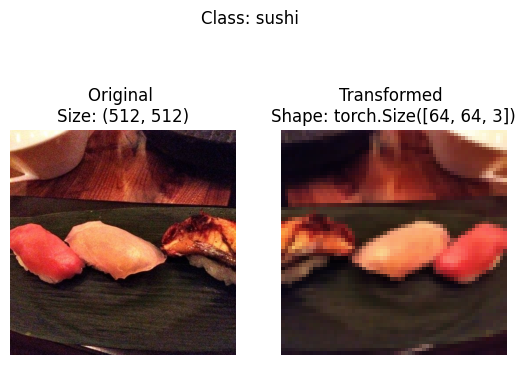

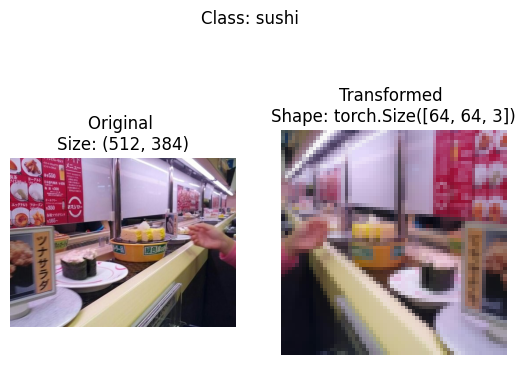

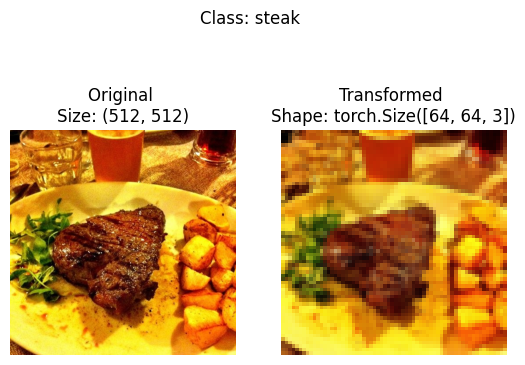

In [18]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
  """ selects random images and transforms image and plot original vs transofrmed image """
  if seed:
    random.seed(seed)

  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize: {f.size}")
      ax[0].axis(False)

      #Transfom image
      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nShape: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}")

plot_transformed_images(image_path_list, data_transform, n=3)

##4. Option 1: Loading image data using ImageFolder

we can load image classisication data using torchvision.datasets.ImageFolder


In [19]:
#Use ImageFolder to create dataset(s)

from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                 transform=data_transform, # transform for the data
                                 target_transform=None # transform for the label/target
                                  )

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform, # transform for the data
                                 )

train_data, test_data


(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/piz za_steak_sushi/train
     StandardTransform
 Transform: Compose(
                ToTensor()
                RandomHorizontalFlip(p=0.5)
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/piz za_steak_sushi/test
     StandardTransform
 Transform: Compose(
                ToTensor()
                RandomHorizontalFlip(p=0.5)
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
            ))

In [20]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [21]:
# get class names as dict

class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [22]:
len(train_data), len(test_data)

(225, 75)

In [23]:
# Index on the train_data Dataset to gte image and label

img, label = train_data[9][0], train_data[9][1]

print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")


Image tensor:
tensor([[[0.1253, 0.1744, 0.1630,  ..., 0.8162, 0.6869, 0.6285],
         [0.1034, 0.1871, 0.1694,  ..., 0.3367, 0.4513, 0.6662],
         [0.0959, 0.1806, 0.1765,  ..., 0.0973, 0.2492, 0.4694],
         ...,
         [0.3377, 0.3474, 0.3563,  ..., 0.1293, 0.1349, 0.1307],
         [0.2968, 0.3418, 0.3576,  ..., 0.1756, 0.1831, 0.1902],
         [0.2252, 0.3004, 0.3260,  ..., 0.1704, 0.1850, 0.1732]],

        [[0.1800, 0.2065, 0.1701,  ..., 0.8728, 0.7571, 0.7045],
         [0.1668, 0.2354, 0.1770,  ..., 0.3746, 0.5049, 0.7537],
         [0.1679, 0.2373, 0.2001,  ..., 0.0896, 0.2713, 0.5529],
         ...,
         [0.1914, 0.1994, 0.1872,  ..., 0.1264, 0.1325, 0.1289],
         [0.1729, 0.1889, 0.1815,  ..., 0.1790, 0.1887, 0.2001],
         [0.1386, 0.1706, 0.1634,  ..., 0.1743, 0.1820, 0.1773]],

        [[0.2632, 0.2848, 0.2163,  ..., 0.9445, 0.8880, 0.9120],
         [0.2562, 0.3329, 0.2484,  ..., 0.4508, 0.6515, 0.8995],
         [0.2620, 0.3556, 0.2850,  ..., 0.16

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


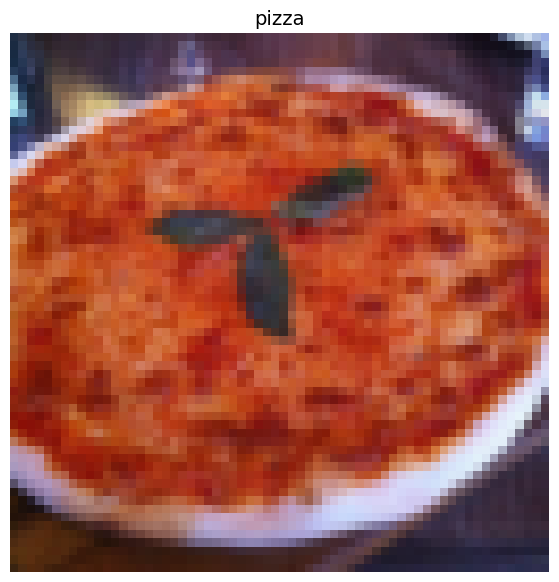

In [24]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

## 4.1 Turn loaded images into DataLoaders

In [25]:
import os
os.cpu_count()

2

In [26]:
# Turn train test ds into Data Loaders

from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1,
                              num_workers=1,
                              shuffle=True)


test_dataloader = DataLoader(dataset=test_data,
                              batch_size=1,
                              num_workers=1,
                              shuffle=False)

# test ste isi always in the same order with shuffle = False

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7de3a1bc2e30>,
 <torch.utils.data.dataloader.DataLoader at 0x7de3a1bc1f30>)

In [27]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
#print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
#print(f"Label shape: {label.shape}")

## 5. Option 2: Loading Image Data with a Custom 'Dataset'

1. Want to be able to load images from file
2. Want to be able to  get class names from the Dataset
3. Want to be able to get classes as a dict from Dataset

Pros:
* Can create a 'Dataset' out of almost anything
* Not limited to PyTorch pre-built 'Dataset' functions

Cons
* Even though you could create a 'Dataset' out of alosmot anything, doesn't mean it will work...
* Using custom 'Dataset' often results in us writing more code, whihc could be prone to errors or performance issues

In [28]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List


In [29]:
# Instance of torchvission.datasets.ImageFolder()

train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

we want a function to:
1. Get the class names using os.scandir() to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dictionary of numerical labels, one for each class.

In [30]:
# Setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

Target directory: data/piz za_steak_sushi/train
Class names found: ['pizza', 'steak', 'sushi']


In [35]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.

    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))

    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [36]:
print(find_classes(target_directory))

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})
